# Analysis of Early Advantages in League of Legends

**Name(s)**: Leo Wiemelt

**Website Link**: https://leowiemelt.github.io/LoL-analysis/

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import plotly.express as px
pd.options.plotting.backend = 'plotly'

## Step 1: Introduction

In [2]:
df = pd.read_csv('2022_LoL_esports_match_data_from_OraclesElixir.csv')
df.shape

/var/folders/4n/gr221w3n74g83smf7w9pzfy00000gn/T/ipykernel_81910/2485156016.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('2022_LoL_esports_match_data_from_OraclesElixir.csv')


(150588, 163)

## Step 2: Data Cleaning and Exploratory Data Analysis

In [3]:
# new columns: kd, kda at 10, 15, 25 min marks
df["kda10"] = (df["killsat10"] + df["assistsat10"]) / df["deathsat10"]
df["kd10"] = df["killsat10"]/ df["deathsat10"]
df["kda15"] = (df["killsat15"] + df["assistsat15"]) / df["deathsat15"]
df["kd15"] = df["killsat15"]/ df["deathsat15"]
df["kda25"] = (df["killsat25"] + df["assistsat25"]) / df["deathsat25"]
df["kd25"] = df["killsat25"]/ df["deathsat25"]

In [4]:
# convert 1/0 to boolean columns
df['playoffs'] = df['playoffs'].astype('bool')
df['result'] = df['result'].astype('bool')
df['firstblood'] = df['firstblood'].astype('bool')
df['firstbloodvictim'] = df['firstbloodvictim'].astype('bool')
df['firstdragon'] = df['firstdragon'].astype('bool')
df['firstherald'] = df['firstherald'].astype('bool')
df['firstbaron'] = df['firstbaron'].astype('bool')
df['firsttower'] = df['firsttower'].astype('bool')
df['firstmidtower'] = df['firstmidtower'].astype('bool')
df['firsttothreetowers'] = df['firsttothreetowers'].astype('bool')

In [5]:
# team rows have missing playerid and player name, with participantid of 100 if blue team, 200 if red, with info about teams
# split dfs into player and team data
teams = df[df["position"] == "team"]
players = df[df["position"] != "team"]
teams.head()


gameid datacompleteness  \
10  ESPORTSTMNT01_2690210         complete   
11  ESPORTSTMNT01_2690210         complete   
22  ESPORTSTMNT01_2690219         complete   
23  ESPORTSTMNT01_2690219         complete   
34       8401-8401_game_1          partial   

                                            url league  year   split  \
10                                          NaN   LCKC  2022  Spring   
11                                          NaN   LCKC  2022  Spring   
22                                          NaN   LCKC  2022  Spring   
23                                          NaN   LCKC  2022  Spring   
34  https://lpl.qq.com/es/stats.shtml?bmid=8401    LPL  2022  Spring   

    playoffs                 date  game  patch  ...  deathsat25 opp_killsat25  \
10     False  2022-01-10 07:44:08     1  12.01  ...         7.0           7.0   
11     False  2022-01-10 07:44:08     1  12.01  ...         6.0           6.0   
22     False  2022-01-10 08:38:24     1  12.01  ...         8.0           8.0   
23     False  2022-01-10 08:38:24     1  12.01  ...         1.0           1.0   
34     False  2022-01-10 09:24:26     1  12.01  ...         NaN           NaN   

   opp_assistsat25 opp_deathsat25     kda10      kd10     kda15      kd15  \
10            22.0            6.0       inf       inf  2.500000  0.833333   
11            12.0            7.0  0.000000  0.000000  4.800000  1.200000   
22            13.0            1.0  0.666667  0.333333  0.666667  0.333333   
23             1.0            8.0  6.000000  3.000000  6.000000  3.000000   
34             NaN            NaN       NaN       NaN       NaN       NaN   

        kda25      kd25  
10   2.571429  0.857143  
11   4.833333  1.166667  
22   0.250000  0.125000  
23  21.000000  8.000000  
34        NaN       NaN  

[5 rows x 169 columns]

In [6]:
# average game length by patch
lengths = teams.groupby('patch')['gamelength'].mean()
px.line(lengths, y=['gamelength'], range_y=[1600, 2000])

In [7]:
px.histogram(players["champion"])

In [8]:
px.histogram(players["totalgold"])

Distribution of gold accumulation for LoL players seems to follows a roughly normal distribution with a longer tail to the right, which is likely affected by the specific roles of players, as some roles have a higher propensity to accumulate gold than others.

In [9]:
# how many games does each player play
games_dist = df.groupby('playerid')["game"].count()
print("Average number of games played:", games_dist.mean())
fig = px.histogram(games_dist, title="Distribution of Number of Games Played", labels={"value": "Games Played", "count": "frequency"})
fig.update_layout(showlegend=False)
fig.show()

Average number of games played: 31.441213976026525


### Distributions of features in wins vs losses

In [10]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

features_to_compare = ['golddiffat15', 'golddiffat25', 'kda15', 'kda25']
fig = make_subplots(rows=2, cols=2, subplot_titles=[f'Distribution of {feature} (Win vs Loss)' for feature in features_to_compare])

for i, feature in enumerate(features_to_compare):
    row = i // 2 + 1
    col = i % 2 + 1

    fig.add_trace(
        go.Histogram(
            x=teams[teams['result'] == 0][feature],
            name='Loss',
            marker_color='red',
            opacity=0.6,
            nbinsx=30,
            showlegend=(i == 0)
        ),
        row=row, col=col
    )

    fig.add_trace(
        go.Histogram(
            x=teams[teams['result'] == 1][feature],
            name='Win',
            marker_color='blue',
            opacity=0.6,
            nbinsx=30,
            showlegend=(i == 0)
        ),
        row=row, col=col
    )

fig.update_layout(
    height=800,
    width=1000,
    title_text="Distributions of Features by Match Outcome",
    barmode='overlay'
)

fig.show()

Observing the distributions of gold and kda metrics at the 15 and 25 minute marks, we see that the winning team typically has a clear advantage in both stats by the 15 minute mark, and this trend is even stronger after 25 minutes.

## Analysis of "Mains"
As the game is patched over time, how do commonly selected champions waver in popularity? Each patch in league of legends changes the competitive environment by adding or changing champions. This effects how players strategize, and can provide interesting insights into early game performance, as choosing a champion is one of the most important decisions that can affact early game data.

In [11]:
# mains: which champion is most commonly "mained" by patch
mains = players.groupby(['patch', 'playerid'])["champion"].agg([
        ('main', lambda x: x.value_counts().idxmax()),
        ('prop', lambda x: x.value_counts().max() / len(x))
    ])
px.histogram(mains["main"])

In [12]:
most_common_mains = (
    mains.reset_index()  # make 'patch' a column again
         .groupby('patch')['main']
         .agg(lambda x: x.value_counts().idxmax())
         .reset_index(name='most_common_main')
)
most_common_mains

patch most_common_main
0   12.01         Xin Zhao
1   12.02         Xin Zhao
2   12.03             Jinx
3   12.04             Jinx
4   12.05         Nautilus
5   12.06         Nautilus
6   12.07         Nautilus
7   12.08         Nautilus
8   12.09         Nautilus
9   12.10           Wukong
10  12.11            Viego
11  12.12             Gnar
12  12.13             Gnar
13  12.14           Wukong
14  12.15             Lulu
15  12.16           Wukong
16  12.17          Caitlyn
17  12.18           Aatrox
18  12.19           Maokai
19  12.20          Sejuani
20  12.21            Viego
21  12.23           Wukong

In [13]:
# gold by position
positions = pd.pivot_table(players, index='position', values='totalgold', aggfunc='mean')
positions

totalgold
position              
bot       13648.169057
jng       10788.157224
mid       12591.318511
sup        7597.691689
top       12293.021874

This table demonstrates the lesser gold-accumulating nature of jungle and support roles. The differing roles of league of legends players is something we should take into account when considering individual player performance, and gold farming will likely be best examined with respect to these roles.

In [14]:
main_counts = (
    mains.reset_index()
         .groupby(['patch', 'main'])
         .size()
         .reset_index(name='count')
)
main_totals = main_counts.groupby('patch')['count'].transform('sum')
main_counts['proportion'] = main_counts['count'] / main_totals

# Limit to top 10 champions
top_champions = main_counts.groupby('main')['count'].sum().nlargest(10).index
main_counts = main_counts[main_counts['main'].isin(top_champions)]

fig = px.area(
    main_counts,
    x='patch',
    y='proportion',
    color='main',
    title='Top Champion Mains Over Patches',
    labels={'main': 'Champion', 'proportion': 'Proportion of Mains'}
)
fig.update_layout(yaxis_tickformat=".0%")
fig.show()

In [15]:
# bivariate analysis, 2 plots: mains over patches, win vs. loss distributions
teams.head()

gameid datacompleteness  \
10  ESPORTSTMNT01_2690210         complete   
11  ESPORTSTMNT01_2690210         complete   
22  ESPORTSTMNT01_2690219         complete   
23  ESPORTSTMNT01_2690219         complete   
34       8401-8401_game_1          partial   

                                            url league  year   split  \
10                                          NaN   LCKC  2022  Spring   
11                                          NaN   LCKC  2022  Spring   
22                                          NaN   LCKC  2022  Spring   
23                                          NaN   LCKC  2022  Spring   
34  https://lpl.qq.com/es/stats.shtml?bmid=8401    LPL  2022  Spring   

    playoffs                 date  game  patch  ...  deathsat25 opp_killsat25  \
10     False  2022-01-10 07:44:08     1  12.01  ...         7.0           7.0   
11     False  2022-01-10 07:44:08     1  12.01  ...         6.0           6.0   
22     False  2022-01-10 08:38:24     1  12.01  ...         8.0           8.0   
23     False  2022-01-10 08:38:24     1  12.01  ...         1.0           1.0   
34     False  2022-01-10 09:24:26     1  12.01  ...         NaN           NaN   

   opp_assistsat25 opp_deathsat25     kda10      kd10     kda15      kd15  \
10            22.0            6.0       inf       inf  2.500000  0.833333   
11            12.0            7.0  0.000000  0.000000  4.800000  1.200000   
22            13.0            1.0  0.666667  0.333333  0.666667  0.333333   
23             1.0            8.0  6.000000  3.000000  6.000000  3.000000   
34             NaN            NaN       NaN       NaN       NaN       NaN   

        kda25      kd25  
10   2.571429  0.857143  
11   4.833333  1.166667  
22   0.250000  0.125000  
23  21.000000  8.000000  
34        NaN       NaN  

[5 rows x 169 columns]

In [16]:
# Filter for specific champions
champion_focus = ['Nautilus', 'Gnar', 'Viego']
filtered = main_counts[main_counts['main'].isin(champion_focus)]

fig = px.line(
    filtered,
    x='patch',
    y='proportion',
    color='main',
    markers=True,
    title='Popularity of Selected Champion Mains Over Patches'
)
fig.update_layout(yaxis_tickformat=".0%")
fig.show()


## Step 3: Assessment of Missingness

### NMAR analysis
The NMAR variables are most likely the ones involving some sort of "first", where matches that didn't have a first would likely not have an entry in the data. Otherwise, most other missing columns appear to be missing completely at random.

In [17]:
from scipy.stats import ks_2samp
kstest = teams.copy()
kstest["missing"] = kstest["golddiffat25"].isna().astype(int)

predictor = "result"
kstest = kstest[["missing", predictor]]

group0 = kstest[kstest["missing"] == 0][predictor]
group1 = kstest[kstest["missing"] == 1][predictor]
real_stat, _ = ks_2samp(group0, group1)

obs = []
for _ in range(1000):
    shuffled = np.random.permutation(kstest["missing"])
    g0 = kstest[shuffled == 0][predictor]
    g1 = kstest[shuffled == 1][predictor]
    stat, _ = ks_2samp(g0, g1)
    obs.append(stat)
p = np.mean(np.array(obs) >= real_stat)
print(f"p value for gold difference at 25 and game length permutation test: {p}")

p value for gold difference at 25 and game length permutation test: 1.0


In [18]:
kstest = teams.copy()
kstest["missing"] = kstest["golddiffat25"].isna().astype(int)

predictor = "killsat25"
kstest = kstest[["missing", predictor]]

group0 = kstest[kstest["missing"] == 0][predictor]
group1 = kstest[kstest["missing"] == 1][predictor]
real_stat, _ = ks_2samp(group0, group1)

obs = []
for _ in range(1000):
    shuffled = np.random.permutation(kstest["missing"])
    g0 = kstest[shuffled == 0][predictor]
    g1 = kstest[shuffled == 1][predictor]
    stat, _ = ks_2samp(g0, g1)
    obs.append(stat)
p = np.mean(np.array(obs) >= real_stat)
print(f"p value for gold difference at 25 and kills at 25 permutation test: {p}")


p value for gold difference at 25 and kills at 25 permutation test: 0.0


When golddiffat25 is missing, killsat25 is always missing as well, not because they are necessarily dependent on each other, but because the entries with "partial" completeness tend to be missing the stats taken at 10, 15, 25, etc. minutes. Thus, if one of these are missing it is generally safe to conclude that the others will be missing as well. On the other hand, the "result" variable is not dependent on the missingness of gold difference at 25 minutes.

## Step 4: Hypothesis Testing

In [19]:
# Does a + difference in gold increase probability of winning the game
# Ha: team with more gold at 25 mins wins more often
# calculate win rate for games with golddiffat25 > 0 and golddiffat25 <= 0, and use perm test
df_clean = teams.dropna(subset=["golddiffat25", "result"])
df_clean = df_clean.assign(pos_gold=df_clean["golddiffat25"] > 0)

win_rate_pos = df_clean[df_clean["pos_gold"]]["result"].mean()
win_rate_neg = df_clean[~df_clean["pos_gold"]]["result"].mean()
observed_diff = win_rate_pos - win_rate_neg

n_permutations = 1000
diffs = []
for _ in range(n_permutations):
    shuffled_result = np.random.permutation(df_clean["result"])
    win_rate_pos_perm = shuffled_result[df_clean["pos_gold"]].mean()
    win_rate_neg_perm = shuffled_result[~df_clean["pos_gold"]].mean()
    diffs.append(win_rate_pos_perm - win_rate_neg_perm)

p_val = np.mean(np.array(diffs) >= observed_diff)
print(f"P-value: {p_val:.4f}")

P-value: 0.0000


In [20]:
# Do more early kills predict winning?
# group by kd25 > 1, compare win rates
df_clean = teams.dropna(subset=["kd25", "result"])
df_clean = df_clean.assign(pos_kd=df_clean["kd25"] >= 1)

win_rate_pos = df_clean[df_clean["pos_kd"]]["result"].mean()
win_rate_neg = df_clean[~df_clean["pos_kd"]]["result"].mean()
observed_diff = win_rate_pos - win_rate_neg

n_permutations = 10000
diffs = []
for _ in range(n_permutations):
    shuffled_result = np.random.permutation(df_clean["result"])
    win_rate_pos_perm = shuffled_result[df_clean["pos_kd"]].mean()
    win_rate_neg_perm = shuffled_result[~df_clean["pos_kd"]].mean()
    diffs.append(win_rate_pos_perm - win_rate_neg_perm)

p_val = np.mean(np.array(diffs) >= observed_diff)
print(f"P-value: {p_val:.4f}")

P-value: 0.0000


These difference in means permutation tests allow us to conclude that teams with an advantage in both Gold and Kills:Deaths at the 25 minute mark have a statistically significant advantage in the overall match.

## Step 5: Framing a Prediction Problem

In [21]:
# binary classifier that predicts which team will win based on gold/xp difference and kills 10, 15, 25 minutes into the game

## Step 6: Baseline Model

### Feature Engineering
Two categorical features: highexperience (whether a player has more than 50 games played) and side will have to be respectively transformed with a Binarizer and One-Hot Encoder to be included into the model. Total games played among players on a team will also be calculated for use in the second iteration of the model. 

In [22]:
# add games of experience to each team entry, along with total number of "highly experienced" players
from sklearn.preprocessing import Binarizer
exp = players.groupby('playerid')["game"].count().reset_index().rename(columns={"game": "gamesplayed"})
binar = Binarizer(threshold=50)
exp['highexperience'] = binar.fit_transform(exp[["gamesplayed"]])
players_exp = players.merge(exp, on="playerid", how='left')

# total experience in each game
game_exp = players_exp.groupby(["gameid", "teamname"])[["gamesplayed", "highexperience"]].sum().reset_index()
team_exp = game_exp.merge(teams, on=["gameid", "teamname"], how="inner")
team_exp.head()

gameid            teamname  gamesplayed  highexperience  \
0  8401-8401_game_1           Oh My God        447.0             5.0   
1  8401-8401_game_1  ThunderTalk Gaming        261.0             3.0   
2  8401-8401_game_2           Oh My God        447.0             5.0   
3  8401-8401_game_2  ThunderTalk Gaming        261.0             3.0   
4  8402-8402_game_1     FunPlus Phoenix        416.0             5.0   

  datacompleteness                                          url league  year  \
0          partial  https://lpl.qq.com/es/stats.shtml?bmid=8401    LPL  2022   
1          partial  https://lpl.qq.com/es/stats.shtml?bmid=8401    LPL  2022   
2          partial  https://lpl.qq.com/es/stats.shtml?bmid=8401    LPL  2022   
3          partial  https://lpl.qq.com/es/stats.shtml?bmid=8401    LPL  2022   
4          partial  https://lpl.qq.com/es/stats.shtml?bmid=8402    LPL  2022   

    split  playoffs  ... deathsat25  opp_killsat25  opp_assistsat25  \
0  Spring     False  ...        NaN            NaN              NaN   
1  Spring     False  ...        NaN            NaN              NaN   
2  Spring     False  ...        NaN            NaN              NaN   
3  Spring     False  ...        NaN            NaN              NaN   
4  Spring     False  ...        NaN            NaN              NaN   

   opp_deathsat25 kda10 kd10 kda15 kd15 kda25 kd25  
0             NaN   NaN  NaN   NaN  NaN   NaN  NaN  
1             NaN   NaN  NaN   NaN  NaN   NaN  NaN  
2             NaN   NaN  NaN   NaN  NaN   NaN  NaN  
3             NaN   NaN  NaN   NaN  NaN   NaN  NaN  
4             NaN   NaN  NaN   NaN  NaN   NaN  NaN  

[5 rows x 171 columns]

## Feature Selection
By combining our understanding of the data with an investigation of the feature correlation matrix, we can identify features that will most successfully predict the winnner of a match based on data early on in the game. We see that the patch version is surprisingly highly uncorrelated with any of these metrics, making it an obvious candidate to omit from the model. From there, we prefer features with significant correlation to the target (result), but low correlation to other features to avoid redundancy/multicollinearity. For example, KDA is definitionally similar to KD, but KD is slightly more predictive than KDA, so KDA will be omitted. These selected features, along with 2 transformed categorical variables (role and experience) will be included as the covariates in the binary classifier.

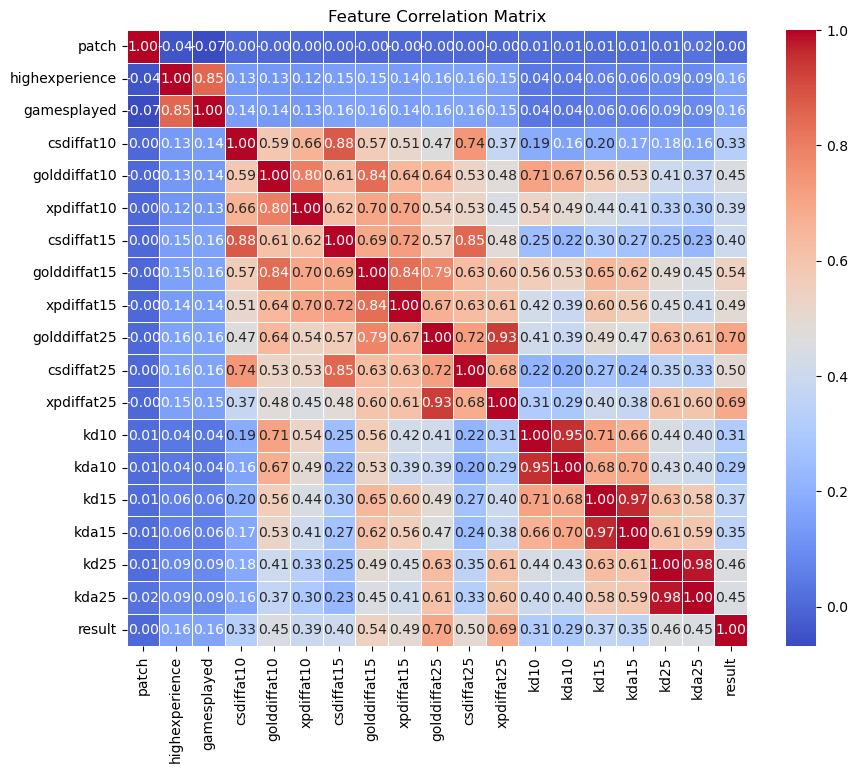

In [23]:
import matplotlib.pyplot as plt
numeric = team_exp[["patch", "highexperience", "gamesplayed", "csdiffat10", "golddiffat10", "xpdiffat10", "csdiffat15", "golddiffat15", "xpdiffat15", "golddiffat25", "csdiffat25", "xpdiffat25", "kd10", "kda10", "kd15", "kda15", "kd25", "kda25", "result"]]
corr_matrix = numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# engineered features: number of more experienced players (binarized), One-Hot encoding for "side"

features = ['golddiffat10', 'golddiffat15', 'golddiffat25', 'kd15', 'kd25', 'kd10', 'highexperience']
cat_feat = ["side"]
df_model = team_exp.replace([np.inf, -np.inf], np.nan, inplace=True)
df_model = team_exp.dropna(subset=(features + cat_feat) + ['result'])
X = df_model[features + cat_feat]
y = df_model["result"]

oh = ColumnTransformer([
    ("num", StandardScaler(), features),
    ("cat", OneHotEncoder(drop="first"), cat_feat)
])

model = Pipeline(steps=[
    ('preprocessing', oh),
    ('classifier', RandomForestClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
model.fit(X_train, y_train)

# Predict and score
predictions = model.predict(X_test)
print("Testing accuracy:", np.round(model.score(X_test, y_test), 3))
print("Training accuracy:", np.round(model.score(X_train, y_train), 3))

Testing accuracy: 0.838
Training accuracy: 1.0


## Step 7: Final Model

The final model will add 2 features: "gamesplayed": total games played by players on the team, and "goldxp": golddiffat25 * xpdiffat25

In [26]:
team_exp["goldxp"] = team_exp["golddiffat25"] * team_exp["xpdiffat25"]

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['golddiffat10', 'golddiffat15', 'golddiffat25', 'kd15', 'kd25', 'kd10', 'goldxp', 'highexperience', 'gamesplayed']
cat_feat = ["side"]
df_model = team_exp.replace([np.inf, -np.inf], np.nan, inplace=True)
df_model = team_exp.dropna(subset=(features + cat_feat) + ['result'])
X = df_model[features + cat_feat]
y = df_model["result"]

oh = ColumnTransformer([
    ("num", StandardScaler(), features),
    ("cat", OneHotEncoder(drop="first"), cat_feat)
])

model = Pipeline(steps=[
    ('preprocessing', oh),
    ('classifier', RandomForestClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
model.fit(X_train, y_train)

# Predict and score
predictions = model.predict(X_test)
print("Testing accuracy:", np.round(model.score(X_test, y_test), 3))
print("Training accuracy:", np.round(model.score(X_train, y_train), 3))

Testing accuracy: 0.844
Training accuracy: 1.0


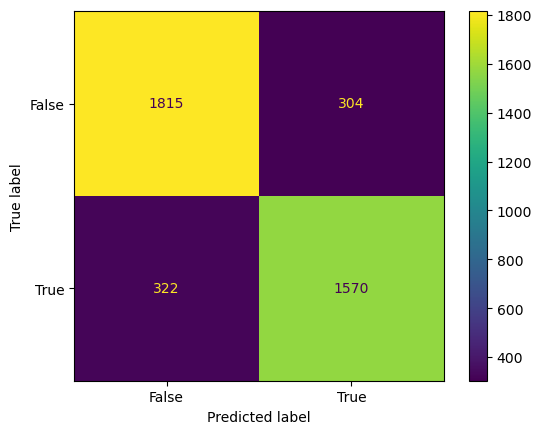

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.grid(False)

## Step 8: Fairness Analysis

Null Hypothesis (H₀): The model is fair; the precision is the same for experienced and inexperienced players.

Alternative Hypothesis (H₁): The model is unfair; precision for experienced players is higher than for inexperienced players.

In [29]:
from sklearn.metrics import precision_score

y_pred = model.predict(X_test)

# Create df for test predictions and grouo info
test_df = X_test.copy()
test_df['y_true'] = y_test
test_df['y_pred'] = y_pred
test_df['group'] = test_df['highexperience'] > 3


In [30]:
# Seperate groups
group_1 = test_df[test_df['group'] == 1]
group_0 = test_df[test_df['group'] == 0]

prec_1 = precision_score(group_1['y_true'], group_1['y_pred'], zero_division=0)
prec_0 = precision_score(group_0['y_true'], group_0['y_pred'], zero_division=0)

obs_diff = prec_1 - prec_0
print(f"Observed precision difference (experienced - inexperienced): {obs_diff:.3f}")


Observed precision difference (experienced - inexperienced): 0.025


In [31]:
# Permutation testing
n_permutations = 1000
diffs = np.array([])
for _ in range(n_permutations):
    shuffled_group = np.random.permutation(test_df['group'].values)
    
    test_df['perm_group'] = shuffled_group
    group_1_perm = test_df[test_df['perm_group'] == 1]
    group_0_perm = test_df[test_df['perm_group'] == 0]

    p1 = precision_score(group_1_perm['y_true'], group_1_perm['y_pred'], zero_division=0)
    p0 = precision_score(group_0_perm['y_true'], group_0_perm['y_pred'], zero_division=0)
    diffs = np.append(diffs, (p1 - p0))


In [32]:
p_value = np.mean(diffs >= obs_diff)
print(f"P-value: {p_value:.3f}")

px.histogram(diffs)


P-value: 0.073


Based on the permutation test, the precision of the model is higher for inexperienced players.